In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools

from amplify import BinaryPoly, gen_symbols, sum_poly
from amplify.client import FixstarsClient
from amplify.constraint import equal_to, penalty, less_equal
from amplify import Solver
from amplify.client import FixstarsClient
from amplify import decode_solution

client = FixstarsClient()
#client.token = "DELETED TOKEN"
client.parameters.timeout = 1000

def show_tatami(row_size, col_size, h_tatami, v_tatami):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylim([0,row_size])
    ax.set_xlim([0,col_size])
    ax.set_aspect('equal')
    ax.set_xticks(range(col_size+1))
    ax.set_yticks(range(row_size+1))
    ax.invert_yaxis()
    ax.xaxis.set_ticks_position('top')
    
    margin = 0.05
    
    for i in range(row_size):
        for j in range(col_size-1):
            if h_tatami[i][j] == 1.0:
                rect = plt.Rectangle((j+margin,i+margin),2-2*margin,1-2*margin,fc="#aa0000")
                ax.add_patch(rect)
    for i in range(row_size-1):
        for j in range(col_size):
            if v_tatami[i][j] == 1.0:
                rect = plt.Rectangle((j+margin,i+margin),1-2*margin,2-2*margin,fc="#000088")
                ax.add_patch(rect) 
    plt.show()

# 畳敷き詰めマシン

与えられた長方形の領域を畳で埋め尽くす。

In [2]:
row_size = 3   # 縦の長さ
col_size = 4   # 横の長さ

In [3]:
h_tatami = np.zeros((row_size, col_size-1))
v_tatami = np.zeros((row_size-1, col_size))

h_tatami_len = row_size*(col_size-1)
q_h = gen_symbols(BinaryPoly, 0, (row_size, col_size-1))
q_v = gen_symbols(BinaryPoly, h_tatami_len, (row_size-1, col_size))

In [4]:
def covering_tatami(row_size, col_size, q_h, q_v, i, j):
    tatami_ls = []
    if j != 0:
        tatami_ls.append(q_h[i][j-1])
    if j != col_size-1:
        tatami_ls.append(q_h[i][j])
    if i != 0:
        tatami_ls.append(q_v[i-1][j])
    if i != row_size-1:
        tatami_ls.append(q_v[i][j])
    return tatami_ls

# 各マスで畳が重ならないための制約
overlap_constraints = itertools.chain.from_iterable([
    [
        less_equal(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j)), 1)
        for i in range(row_size)] for j in range(col_size)
    ]
)

constraints = sum(overlap_constraints)

In [5]:
cost_h = sum_poly([sum_poly([q_h[i][j] for j in range(col_size-1)]) for i in range(row_size)])
cost_v = sum_poly([sum_poly([q_v[i][j] for j in range(col_size)]) for i in range(row_size-1)])
cost = cost_h + cost_v
constraints *= row_size*col_size   # 制約条件の強さを設定
model = - cost + constraints

In [6]:
solver = Solver(client)

result = solver.solve(model)
if len(result) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

energy, values = result[0].energy, result[0].values

In [7]:
q_h_values = decode_solution(q_h, values, 1)
q_v_values = decode_solution(q_v, values, 1)

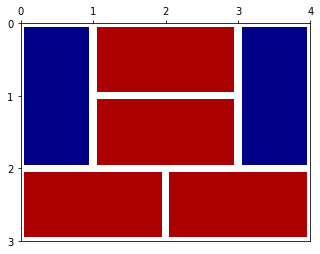

In [8]:
show_tatami(row_size, col_size, q_h_values, q_v_values)

# 最小畳配置問題ソルバー

出来るだけ少ない枚数でそれ以上畳を置けなくするという問題を考える。\
以下に3x3と4x4の場合の解を示す。\
（同じ番号は同じ畳であることを、■は畳が置かれていないマスを意味する）

3x3の例：\
①①■\
■②②\
③③■

4x4の例：\
①①■②\
■③③②\
④⑤⑤■\
④■⑥⑥

In [9]:
row_size = 10   # 縦の長さ
col_size = 10   # 横の長さ

In [10]:
h_tatami = np.zeros((row_size, col_size-1))
v_tatami = np.zeros((row_size-1, col_size))

h_tatami_len = row_size*(col_size-1)
q_h = gen_symbols(BinaryPoly, 0, (row_size, col_size-1))
q_v = gen_symbols(BinaryPoly, h_tatami_len, (row_size-1, col_size))

In [11]:
def covering_tatami(row_size, col_size, q_h, q_v, i, j):
    tatami_ls = []
    if j != 0:
        tatami_ls.append(q_h[i][j-1])
    if j != col_size-1:
        tatami_ls.append(q_h[i][j])
    if i != 0:
        tatami_ls.append(q_v[i-1][j])
    if i != row_size-1:
        tatami_ls.append(q_v[i][j])
    return tatami_ls

# 各マスで畳が重ならないための制約
overlap_constraints = itertools.chain.from_iterable([
    [
        -sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j))
                *(1-sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j)))
        for i in range(row_size)] for j in range(col_size)
    ]
)

# 空きマスが隣り合わないための制約
nomoretatami_h_constraints = itertools.chain.from_iterable([
    [
        (1-(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j))
                +(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j+1)))
                -q_h[i][j]))
            *(2-(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j))
                +(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j+1)))
                -q_h[i][j]))
        for i in range(row_size)] for j in range(col_size-1)
    ]
)
nomoretatami_v_constraints = itertools.chain.from_iterable([
    [
        (1-(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j))
                          +(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i+1, j)))
                          -q_v[i][j]))
            *(2-(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i, j))
                          +(sum_poly(covering_tatami(row_size, col_size, q_h, q_v, i+1, j)))
                          -q_v[i][j]))
        for i in range(row_size-1)] for j in range(col_size)
    ]
)
constraints = sum(overlap_constraints) + sum(nomoretatami_h_constraints) + sum(nomoretatami_v_constraints)

cost_h = sum_poly([sum_poly([q_h[i][j] for j in range(col_size-1)]) for i in range(row_size)])
cost_v = sum_poly([sum_poly([q_v[i][j] for j in range(col_size)]) for i in range(row_size-1)])
cost = cost_h + cost_v

constraints *= 1   # 制約条件の強さを設定
model = cost + constraints

In [12]:
client.parameters.timeout = 5000  # タイムアウト5秒

solver = Solver(client)

In [13]:
result = solver.solve(model)
if len(result) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

energy, values = result[0].energy, result[0].values

In [14]:
q_h_values = decode_solution(q_h, values, 1)
q_v_values = decode_solution(q_v, values, 1)

畳の枚数 34


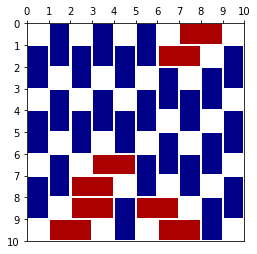

In [15]:
print("畳の枚数", int(energy))
show_tatami(row_size, col_size, q_h_values, q_v_values)